# Assessment of vancomycin vs. another antibiotic

In clinical practice, the pertinent question is often not "should I use vancomycin?", but rather "should I use vancomycin or this other antibiotic?". This notebook aims to quantify the risk of nephrotoxicity when using vancomycin over the other antibiotic.


## Definitions

* **drug on admission:** patient received medication order -12 to 12 hours upon admission to the ICU
* **baseline creatinine:** first creatinine value between -12 to 12 hours upon admission to the ICU
* **AKI:** following KDIGO guidelines using only creatinine, any instance of AKI between 2-7 days after their ICU admission. 
    * In this notebook, AKI = Only Stage 2 and 3. VPT has been shown to increase SCr without causing tubular damage and this slight increase might be enough to classify as Stage 1. 

## 0. Setup

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print(pd.__version__) # Must be downgraded for pymatch.Matcher to work
import psycopg2
from tqdm import tqdm_notebook as tqdm
from lifelines import NelsonAalenFitter

# helper functions stored in local py file
import utils

0.23.4


# 1. Extract data and apply exclusions

For more detail on exclusions, see the main vancomycin analysis notebook.

In [2]:
# cohort with exclusions applied
co = pd.read_csv('data/cohort.csv.gz')

In [3]:
# covariates from APACHE table
dem = pd.read_csv('data/demographics.csv.gz')

# manually add in BMI exclusion bc cohort was extracted prior
co['exclude_bmi'] = 1
patids = dem[dem['bmi_group'].notnull()]['patientunitstayid']
co.loc[co['patientunitstayid'].isin(patids), 'exclude_bmi'] = 0

# obese patients were classified as overweight bc error in sql code
display(dem['bmi_group'].value_counts())
dem.loc[dem['bmi'] >= 30, 'bmi_group'] = 'obese'
display(dem['bmi_group'].value_counts())
dem['bmi_group'].value_counts()

# add length of stay in days
dem['hospital_los_days'] = np.ceil(dem['hospital_los_hours'] / 24.)

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


overweight     2033838
normal          850638
underweight      80615
Name: bmi_group, dtype: int64

obese          1148586
overweight      885252
normal          850638
underweight      80615
Name: bmi_group, dtype: int64

Below we summarize the initial population size and the exclusions resulting in the final population

In [4]:
# remove corrupt hospitals & admissions before 2005 before summarizing the cohort

# for some of the exclusions, we don't want to include them in the denominator
# mainly they are unrelated to actual patient case-mix
pre_exclude = ('exclude_corrupt_hospitals', 'exclude_before_2005')

for c in pre_exclude:
    co = co.loc[co[c]==0]

print('== EXCLUSIONS - TOTAL ==')
N = co.shape[0]
print(f'{N:6d} unique unit stays.')
for c in co.columns:
    if c in pre_exclude:
        continue

    if c.startswith('exclude_'):
        N = co[c].sum()
        mu = co[c].mean()*100.0
        print(f'  {N:6d} ({mu:4.1f}%) - {c}')
        
print('\n== EXCLUSIONS - SEQUENTIAL ==')
N = co.shape[0]
print(f'{N:7d} unique unit stays.')
idx = co['patientunitstayid'].notnull()
for c in co.columns:
    if c in pre_exclude:
        continue

    if c.startswith('exclude_'):
        # index patients removed by this exclusion
        idxRem = (co[c]==1)
        # calculate number of patients being removed, after applying prev excl
        N = (idx & idxRem).sum()
        mu = N/co.shape[0]*100.0
        idx = idx & (~idxRem)
        n_rem = idx.sum()
        
        print(f'- {N:5d} = {n_rem:6d} ({mu:4.1f}% removed) - {c}')
        
        
# create a cohort ID variable
co_id = set(co.loc[idx, 'patientunitstayid'])

== EXCLUSIONS - TOTAL ==
3089748 unique unit stays.
  438245 (14.2%) - exclude_sdu
  116797 ( 3.8%) - exclude_short_stay
  1833830 (59.4%) - exclude_non_ed_admit
  2115226 (68.5%) - exclude_secondary_stay
  1570462 (50.8%) - exclude_missing_apache
  484535 (15.7%) - exclude_no_med_interface
  111555 ( 3.6%) - exclude_dialysis_chronic
  299980 ( 9.7%) - exclude_dialysis_first_week
  513293 (16.6%) - exclude_cr_missing_baseline
  1192358 (38.6%) - exclude_cr_missing_followup
  346806 (11.2%) - exclude_bmi

== EXCLUSIONS - SEQUENTIAL ==
3089748 unique unit stays.
- 438245 = 2651503 (14.2% removed) - exclude_sdu
- 80573 = 2570930 ( 2.6% removed) - exclude_short_stay
- 1409906 = 1161024 (45.6% removed) - exclude_non_ed_admit
- 255882 = 905142 ( 8.3% removed) - exclude_secondary_stay
- 280553 = 624589 ( 9.1% removed) - exclude_missing_apache
- 99260 = 525329 ( 3.2% removed) - exclude_no_med_interface
- 17496 = 507833 ( 0.6% removed) - exclude_dialysis_chronic
- 37922 = 469911 ( 1.2% removed)

In [5]:
# abx drug doses
va = pd.read_csv('data/vanco.csv.gz')
ce = pd.read_csv('data/cefepime.csv.gz')
zo = pd.read_csv('data/zosyn.csv.gz')
li = pd.read_csv('data/linezolid.csv.gz')
me = pd.read_csv('data/meropenem.csv.gz')
aki = pd.read_csv('data/aki.csv.gz')

# consider aki as stage 2, 3 as defined by KDIGO criteria
aki['aki'] = 0
aki.loc[aki['stage'].isin([2,3]), 'aki'] = 1 

# APACHE
apache = pd.read_csv('data/apache.csv.gz')

# convert apache predictions into numeric
apache['apache_prob'] = pd.to_numeric(apache['apache_prob'])

# sepsis/infection/organ failure
dx = pd.read_csv('data/sepsis_infection.csv.gz')

# nephrotoxic agent exposure
neph = pd.read_csv('data/nephrotoxic_agents.csv.gz')
# neph data covers contrast + some of (nsaids, vasopressors and calcineurin inhibs)
# Other nephrotoxic drugs. 
ag = pd.read_csv('data/aminoglycosides.csv.gz')
ag['agent'] = 'aminoglycosides'
amp = pd.read_csv('data/amphotericin.csv.gz')
amp['agent'] = 'amphotericin'
av = pd.read_csv('data/antivirals.csv.gz')
av['agent'] = 'antivirals'
cn = pd.read_csv('data/calcineurin_inhibitors.csv.gz')
cn['agent'] = 'calcineurin_inh'
ld = pd.read_csv('data/loop_diuretics.csv.gz')
ld['agent'] = 'loop_diuretics'
ns = pd.read_csv('data/nsaids.csv.gz')
ns['agent'] = 'nsaids'
vp = pd.read_csv('data/vasopressors.csv.gz')
vp['agent'] = 'vasopressors'

neph_all = utils.consolidate_neph_exp(ag, amp, av, cn, ld, ns, vp, neph)

## Merge data

The antibiotic administration data extracted above has all administrations from time 0.
Thus, three dataframes need to be extracted before we can merge data:

1. Extract vanco_adm and vanco_wk
2. Extract cefepime_adm and cefepime_wk
3. Extract zosyn_adm and zosyn_wk

In [6]:
v_df = utils.extract_adm_and_wk(va, 'vanco')
c_df = utils.extract_adm_and_wk(ce, 'cefepime')
z_df = utils.extract_adm_and_wk(zo, 'zosyn')
l_df = utils.extract_adm_and_wk(li, 'linezolid')
m_df = utils.extract_adm_and_wk(me, 'meropenem')

v_df.head()

,vanco_adm,vanco_wk
patientunitstayid,,
9,1,0
15,1,1
20,1,1
21,0,0
23,1,1


In [7]:
pd.crosstab(v_df['vanco_adm'], v_df['vanco_wk'])

vanco_wk,0,1
vanco_adm,,
0,82717,156471
1,191855,173867


We have two variables here: `vanco_adm` and `vanco_wk`.

* `vanco_adm`: did the patient receive vancomycin on ICU admission (+- 12 hours from ICU in time)
* `vanco_wk`: did the patient receive vancomycin at some time >= 48 hours after ICU admission

We then create the `vanco` flag, which requires both to be true. This filters to patients who were administered vancomycin on ICU admission for at least 48 hours.

A similar process is carried out for the other antibiotics.

## Apply exclusions and create final dataframe

The `prepare_dataframe` function merges the data into a single dataframe, applying exclusions from `co` and subselecting certain variables.

In particular, this function will create a `vanco` column, which is equal to `(vanco_adm == 1) & (vanco_wk == 1)`.
Similarly it will create a `cefepime` and `zosyn` column

In [8]:
def summarize_abx_use(df):
    print('{} patients.'.format(df.shape[0]))

    print('Antibiotic use for 48 hours in the ICU:')
    for abx in ['vanco', 'cefepime', 'zosyn', 'linezolid', 'meropenem']:
        N = df[abx].sum()
        mu = N/df.shape[0]*100.0
        print(f'  {N:5d} ({mu:4.1f}%) - {abx}')


    print('\nConcurrent antibiotic use:')
    concurrent_abx = [
        ['vanco', 'cefepime'],
        ['vanco', 'zosyn'],
        ['vanco', 'meropenem']
    ]
    for abx1, abx2 in concurrent_abx:
        N = ((df[abx1] == 1) & (df[abx2] == 1)).sum()
        mu = N/df.shape[0]*100.0
        print(f'  {N:5d} ({mu:4.1f}%) - {abx1} & {abx2}')

In [9]:
df = utils.prepare_dataframe(co, dem, aki, neph_all, apache, dx, drug_dfs=[v_df, c_df, z_df, l_df, m_df])
    
df.head()

,age,gender,hospitalid,hospitaldischargeyear,ethnicity,weight_avg,height_cm,bmi,hospital_los_hours,hospital_admit_source,...,cefepime,zosyn_adm,zosyn_wk,zosyn,linezolid_adm,linezolid_wk,linezolid,meropenem_adm,meropenem_wk,meropenem
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141139,50,Male,56,2014,Caucasian,111.27,193.0,30.0,90.083333,Emergency Department,...,0,0,0,0,0,0,0,0,0,0
141144,65,Female,58,2012,Caucasian,102.71,167.6,37.0,474.183333,Emergency Department,...,0,0,0,0,0,0,0,0,0,0
141151,67,Male,56,2012,Caucasian,86.05,172.5,29.0,72.583333,Emergency Department,...,0,0,0,0,0,0,0,0,0,0
141156,90,Male,73,2014,Caucasian,76.10,172.7,26.0,68.333333,Emergency Department,...,0,0,0,0,0,0,0,0,0,0
141159,61,Male,73,2013,African American,63.91,170.2,22.0,130.283333,Emergency Department,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# calculate proportion of various abx usage
summarize_abx_use(df)

252170 patients.
Antibiotic use for 48 hours in the ICU:
  29985 (11.9%) - vanco
   6974 ( 2.8%) - cefepime
  30510 (12.1%) - zosyn
    953 ( 0.4%) - linezolid
   2474 ( 1.0%) - meropenem

Concurrent antibiotic use:
   3147 ( 1.2%) - vanco & cefepime
  12454 ( 4.9%) - vanco & zosyn
   1096 ( 0.4%) - vanco & meropenem


# Demographics

In [11]:
from collections import OrderedDict
comparisons = OrderedDict()

idxCefepime = df['cefepime_adm'] == 1
idxZosyn = df['zosyn_adm'] == 1
idxVanco = df['vanco_adm'] == 1
idxMero = df['meropenem_adm'] == 1

idxVZ = idxVanco & idxZosyn & ~idxCefepime & ~idxMero
idxVC = idxVanco & ~idxZosyn & idxCefepime & ~idxMero
idxVM = idxVanco & ~idxZosyn & ~idxCefepime & idxMero

# summarize exclusions
idxNoAbx = ~idxCefepime & ~idxZosyn & ~idxVanco & ~idxMero
n = idxNoAbx.sum()
print(f'{n} / {df.shape[0]} ({n/df.shape[0]*100:3.1f}%) did not receive ABX.')

n = (~idxNoAbx & ~(idxVZ | idxVC | idxVM)).sum()
print(f'{n} / {df.shape[0]} ({n/df.shape[0]*100:3.1f}%) received more than one ABX.')

dd = df.copy()
dd['abx'] = 'v+z'
dd.loc[idxVC, 'abx'] = 'v+c'
dd.loc[idxVM, 'abx'] = 'v+m'
dd = dd.loc[idxVZ | idxVC | idxVM]
print(dd.shape)
dd.head()

177683 / 252170 (70.5%) did not receive ABX.
42099 / 252170 (16.7%) received more than one ABX.
(32388, 53)


,age,gender,hospitalid,hospitaldischargeyear,ethnicity,weight_avg,height_cm,bmi,hospital_los_hours,hospital_admit_source,...,zosyn_adm,zosyn_wk,zosyn,linezolid_adm,linezolid_wk,linezolid,meropenem_adm,meropenem_wk,meropenem,abx
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141187,42,Male,73,2012,NaN,88.00,165.1,32.0,194.483333,Emergency Department,...,0,0,0,0,0,0,0,0,0,v+c
141241,36,Female,66,2013,Caucasian,101.45,160.0,40.0,358.300000,NaN,...,1,0,0,0,1,0,0,0,0,v+z
141332,56,Male,63,2014,Caucasian,93.90,177.8,30.0,163.316667,NaN,...,0,0,0,0,0,0,0,0,0,v+c
141356,87,Male,66,2015,Caucasian,78.86,180.3,24.0,250.716667,Emergency Department,...,1,0,0,0,0,0,0,0,0,v+z
141549,73,Male,73,2013,Caucasian,93.23,167.6,33.0,129.766667,NaN,...,1,1,1,0,0,0,0,0,0,v+z


In [12]:
from tableone import TableOne

# Impute Unknown for missing values 
dd.loc[dd['ethnicity'].isnull(), 'ethnicity'] = 'Other/Unknown'
dd.loc[dd['region'].isnull(), 'region'] = 'Unknown'
dd.loc[dd['teachingstatus'].isnull(), 'teachingstatus'] = 'Unknown'
dd.loc[dd['numbedscategory'].isnull(), 'numbedscategory'] = 'Unknown'

cols = [
    'age', 'gender', 'ethnicity', 'bmi', 'bmi_group', 'apachescore',
    'egfr',
    'immunocompromised',
    'abx',
    'aki', 'stage',
    'nephrotoxic_exp',
    'hospital_los_hours',
    'hospital_los_days',
    'hospital_disch_location',
    'hospital_mortality',
    'region', 'teachingstatus', 'numbedscategory'
]
categorical = ['ethnicity', 'gender', 'immunocompromised', 'abx', 'hospital_disch_location',
              'region', 'teachingstatus', 'numbedscategory',
              'aki', 'hospital_mortality',
              'stage', 'nephrotoxic_exp', 'bmi_group'
              ]

col_order = {
    'bmi_group': ['underweight', 'normal', 'overweight', 'obese'], 
    'numbedscategory': ['<100', '100-249', '250-500', '>500', 'Unknown'],
    'region': ['Northeast', 'South','Midwest', 'West', 'Unknown'],
    'hospital_disch_location': ['Death', 'Home', 'NursingHome', 'SNF', 'OtherHospital', 'OtherExternal', 'Other']
    
}
t1 = TableOne(dd.reset_index(), columns=cols, categorical=categorical, groupby='abx', order=col_order)
t1

Grouped by abx                                                            
                                                       Missing        Overall            v+c            v+m            v+z
n                                                                       32388           5872           1704          24812
age, mean (SD)                                               0    65.6 (16.3)    66.2 (15.7)    64.4 (16.3)    65.6 (16.5)
gender, n (%)                  Female                        0   14804 (45.7)    2803 (47.7)     866 (50.8)   11135 (44.9)
                               Male                              17583 (54.3)    3069 (52.3)     837 (49.1)   13677 (55.1)
                               Other                                  1 (0.0)                       1 (0.1)               
ethnicity, n (%)               African American              0    3562 (11.0)     611 (10.4)     245 (14.4)    2706 (10.9)
                               Asian                                430 (1.3)       60 (1.0)       31 (1.8)      339 (1.4)
                               Caucasian                         24906 (76.9)    4755 (81.0)    1240 (72.8)   18911 (76.2)
                               Hispanic                            1773 (5.5)      207 (3.5)       61 (3.6)     1505 (6.1)
                               Native American                      275 (0.8)       31 (0.5)        5 (0.3)      239 (1.0)
                               Other/Unknown                       1442 (4.5)      208 (3.5)      122 (7.2)     1112 (4.5)
bmi, mean (SD)                                               0     28.6 (9.2)     29.0 (9.3)     28.8 (9.8)     28.5 (9.2)
bmi_group, n (%)               underweight                   0     1467 (4.5)      255 (4.3)       93 (5.5)     1119 (4.5)
                               normal                            10467 (32.3)    1804 (30.7)     548 (32.2)    8115 (32.7)
                               overweight                         8672 (26.8)    1558 (26.5)     444 (26.1)    6670 (26.9)
                               obese                             11782 (36.4)    2255 (38.4)     619 (36.3)    8908 (35.9)
apachescore, mean (SD)                                       0    69.0 (25.8)    68.9 (24.8)    70.3 (25.7)    69.0 (26.0)
egfr, mean (SD)                                              0    72.2 (57.7)    73.3 (61.7)    71.4 (59.9)    72.0 (56.5)
immunocompromised, n (%)       no                            0   30575 (94.4)    5301 (90.3)    1589 (93.3)   23685 (95.5)
                               yes                                 1813 (5.6)      571 (9.7)      115 (6.7)     1127 (4.5)
abx, n (%)                     v+c                           0    5872 (18.1)   5872 (100.0)                              
                               v+m                                 1704 (5.3)                  1704 (100.0)               
                               v+z                               24812 (76.6)                                24812 (100.0)
aki, n (%)                     0                             0   29092 (89.8)    5406 (92.1)    1550 (91.0)   22136 (89.2)
                               1                                  3296 (10.2)      466 (7.9)      154 (9.0)    2676 (10.8)
stage, n (%)                   0                             0   26528 (81.9)    4982 (84.8)    1440 (84.5)   20106 (81.0)
                               1                                   2564 (7.9)      424 (7.2)      110 (6.5)     2030 (8.2)
                               2                                   1561 (4.8)      206 (3.5)       65 (3.8)     1290 (5.2)
                               3                                   1735 (5.4)      260 (4.4)       89 (5.2)     1386 (5.6)
nephrotoxic_exp, n (%)         0                             0    8814 (27.2)    1551 (26.4)     421 (24.7)    6842 (27.6)
                               1                                 23574 (72.8)    4321 (73.6)    1283 (75.3)   17

# Time to AKI

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/lifelines/fitters/__init__.py:136: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_cumulative_hazard_`
  DeprecationWarning,
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/lifelines/fitters/__init__.py:136: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_cumulative_hazard_`
  DeprecationWarning,
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/lifel

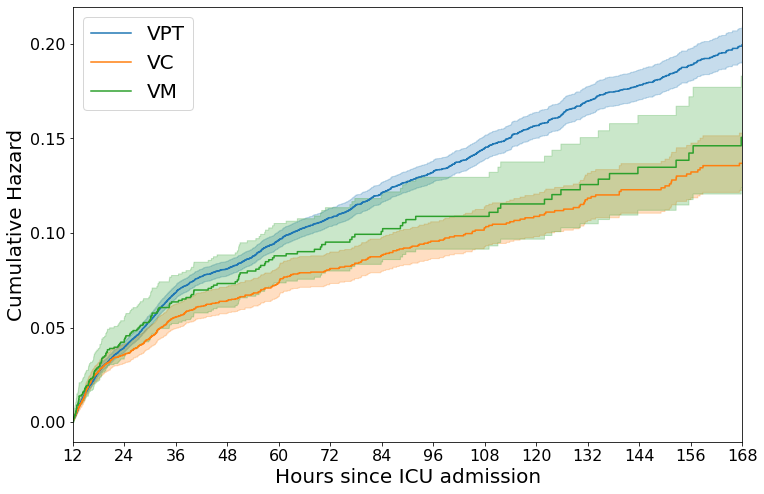

In [13]:
idxCefepime = df['cefepime_adm'] == 1
idxZosyn = df['zosyn_adm'] == 1
idxVanco = df['vanco_adm'] == 1
idxMero = df['meropenem_adm'] == 1

idxVZ = idxVanco & idxZosyn & ~idxCefepime & ~idxMero
idxVC = idxVanco & ~idxZosyn & idxCefepime & ~idxMero
idxVM = idxVanco & ~idxZosyn & ~idxCefepime & idxMero

def plot_hazard_line(idx, label, aki):
    tm_to_aki = df.loc[idx, [aki, 'chartoffset_aki', 'unitdischargeoffset']].copy()

    tm_to_aki['time'] = tm_to_aki['chartoffset_aki']
    idx = tm_to_aki[aki] == 0
    tm_to_aki.loc[idx, 'time'] = tm_to_aki.loc[idx, 'unitdischargeoffset']

    # convert time from minutes to hours
    tm_to_aki['time'] = tm_to_aki['time'] / 60.0

    naf = NelsonAalenFitter()
    naf.fit(tm_to_aki['time'].values, event_observed=tm_to_aki[aki].values)
    naf.plot(label=label)

aki_def = 'aki'
# plot a line for each group
plt.figure(figsize=[12, 8])
plot_hazard_line(idxVZ, 'VPT', aki_def)
plot_hazard_line(idxVC, 'VC', aki_def)
plot_hazard_line(idxVM, 'VM', aki_def)

plt.xlim([12, 7*24])
plt.xticks(range(12, 7*24+1, 12), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Cumulative Hazard', fontsize=20)
plt.xlabel('Hours since ICU admission', fontsize=20)
plt.legend(fontsize=20)
plt.show()

# Analyses: AKI = Stage 1, 2, 3

- Primary: drug on adm
- Secondary: drug on adm *for at least 48 hr* (adm + "wk")


We will compare three groups of patients: 

* vancomycin and zosyn
* vancomycin and cefepime
* vancomycin and meropenem

In order to make this comparison clear, we'll define all the groups upfront, then later run the comparison.

In [14]:
comparisons = OrderedDict()
covariates = [
        'age', 'apache_prob', 'immunocompromised', 'egfr', 'nephrotoxic_exp', 'bmi_group'
    ]
vars_include = covariates + ['aki']

idxCefepime = df['cefepime_adm'] == 1
idxZosyn = df['zosyn_adm'] == 1
idxVanco = df['vanco_adm'] == 1
idxMero = df['meropenem_adm'] == 1

idxVZ = idxVanco & idxZosyn & ~idxCefepime & ~idxMero
idxVC = idxVanco & ~idxZosyn & idxCefepime & ~idxMero
idxVM = idxVanco & ~idxZosyn & ~idxCefepime & idxMero

# Vanco + Zosyn vs Vanco + Cefepime
comparisons['v+z vs. v+c'] = {
    'exposure': df[idxVC].copy()[vars_include],
    'control': df[idxVZ].copy()[vars_include], 
    'covariates': covariates,
    'seed': 1000,
    'balance': True
}

# Vanco + Zosyn vs Vanco + Meropenem
comparisons['v+z vs. v+m'] = {
    'exposure': df[idxVM].copy()[vars_include], 
    'control': df[idxVZ].copy()[vars_include], 
    'covariates': covariates,
    'seed': 1001,
    'balance': True
}

# repeat where we require exposure to be for at least 48 hours
idxCefepime_48hr = df['cefepime'] == 1
idxZosyn_48hr = df['zosyn'] == 1
idxVanco_48hr = df['vanco'] == 1
idxMero_48hr = df['meropenem'] == 1

idxVZ_48hr = idxVanco_48hr & idxZosyn_48hr & ~idxCefepime_48hr & ~idxMero_48hr
idxVC_48hr = idxVanco_48hr & ~idxZosyn_48hr & idxCefepime_48hr & ~idxMero_48hr
idxVM_48hr = idxVanco_48hr & ~idxZosyn_48hr & ~idxCefepime_48hr & idxMero_48hr


# Vanco + Zosyn vs Vanco + Cefepime
comparisons['v+z vs. v+c, 48hr'] = {
    'exposure': df[idxVC_48hr].copy()[vars_include], 
    'control': df[idxVZ_48hr].copy()[vars_include], 
    'covariates': covariates,
    'seed': 1002,
    'balance': True
}

# Vanco + Zosyn vs Vanco + Meropenem
comparisons['v+z vs. v+m, 48hr'] = {
    'exposure': df[idxVM_48hr].copy()[vars_include], 
    'control': df[idxVZ_48hr].copy()[vars_include], 
    'covariates': covariates,
    'seed': 1003,
    'balance': True
}

print('Comparisons coded in dictionary:')
print(comparisons.keys())

Comparisons coded in dictionary:
odict_keys(['v+z vs. v+c', 'v+z vs. v+m', 'v+z vs. v+c, 48hr', 'v+z vs. v+m, 48hr'])


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Propensity score comparison

With the dataset defined, we can run the propensity score modeling followed by caliper matching to create two groups matched on the confounders.

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


=====v+z vs. v+c=====
Exposure:  5872 (19.1%)
Control: 24812 (80.9%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 24812
n minority: 5872
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.4%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000000,1.000000
1,nephrotoxic_exp,0.075114,0.501529
2,bmi_group,0.002347,0.792104


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.003,0.362,0.001,0.584,0.061167,0.000000,0.037019,-0.011868
1,apache_prob,0.000,0.119,1.000,1.000,0.024938,0.019526,-0.007135,-0.010475
2,egfr,0.260,0.368,0.831,0.841,0.009387,0.008055,0.022787,0.012361


Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 0.73 [0.65 - 0.83].
=====v+z vs. v+m=====
Exposure:  1704 ( 6.4%)
Control: 24812 (93.6%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 24812
n minority: 1704
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 52.93%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000039,0.836383
1,nephrotoxic_exp,0.011066,0.603593
2,bmi_group,0.288005,0.975373


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.002,0.825,0.003,0.653,-0.060671,0.000000,-0.070868,0.007740
1,apache_prob,0.075,0.029,1.000,1.000,0.047357,0.066956,0.017601,0.064061
2,egfr,0.267,0.090,0.315,0.019,-0.019320,-0.050136,-0.011673,-0.002605


Result of propensity score followed by matching:
p = 0.009.
Odds ratio: 0.74 [0.60 - 0.93].
=====v+z vs. v+c, 48hr=====
Exposure:  3055 (19.8%)
Control: 12344 (80.2%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 12344
n minority: 3055
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.35%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000000,1.000000
1,nephrotoxic_exp,0.456529,0.197766
2,bmi_group,0.077425,0.970646


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.065,0.218,0.008,0.138,0.000000,0.000000,0.009446,0.028987
1,apache_prob,0.139,0.158,1.000,1.000,0.002957,0.026168,-0.031183,0.020463
2,egfr,0.911,0.116,0.654,0.201,-0.011059,-0.021779,0.002636,-0.007517


Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 0.73 [0.61 - 0.87].
=====v+z vs. v+m, 48hr=====
Exposure:  1066 ( 7.9%)
Control: 12344 (92.1%)
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 12344
n minority: 1066
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.28%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000206,0.935932
1,nephrotoxic_exp,0.449190,0.725091
2,bmi_group,0.616818,0.884641


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.000,0.631,0.000,0.253,-0.061327,0.061775,-0.095099,0.000174
1,apache_prob,0.091,0.071,1.000,1.000,0.066241,0.055108,0.047755,0.012493
2,egfr,0.169,0.144,0.041,0.307,-0.030240,-0.060554,0.067379,0.010127


Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 0.48 [0.35 - 0.66].


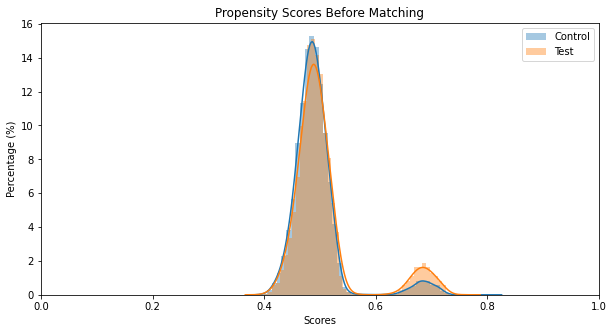

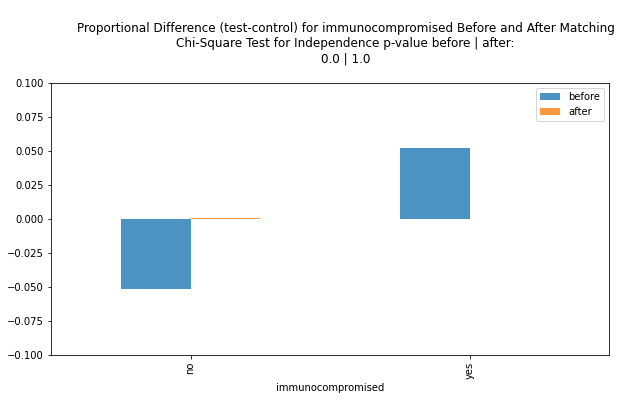

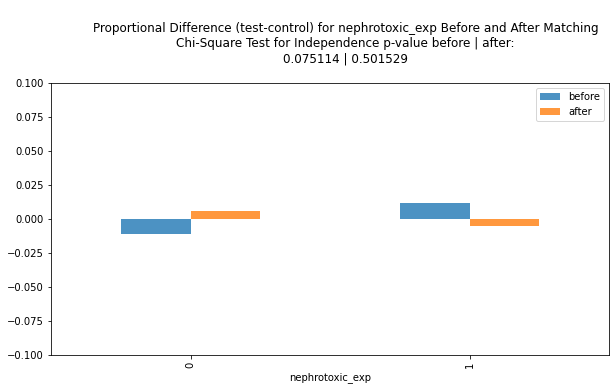

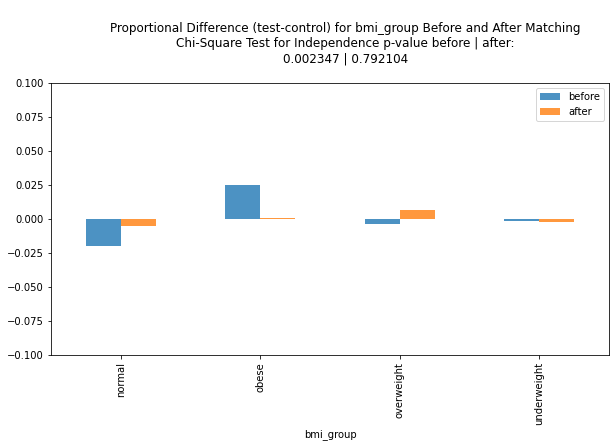

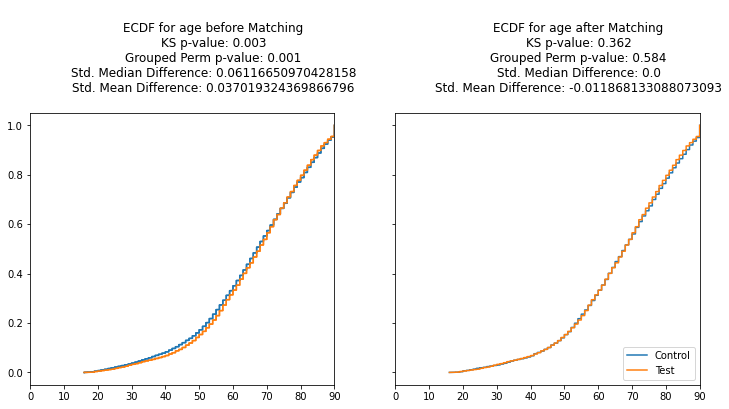

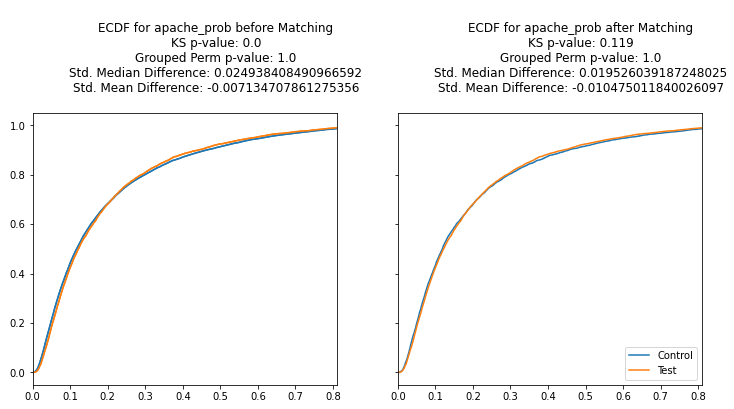

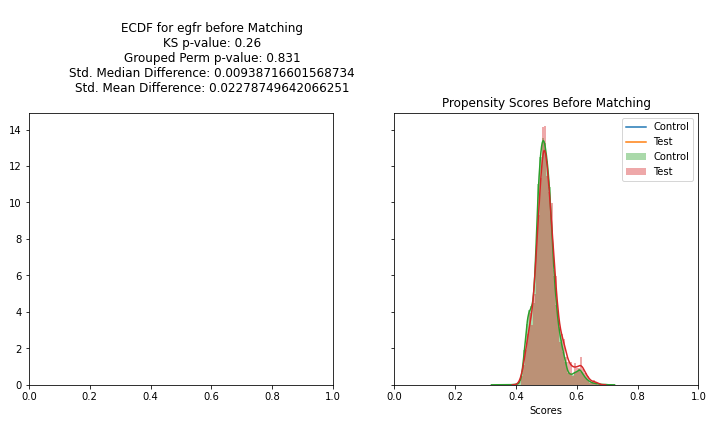

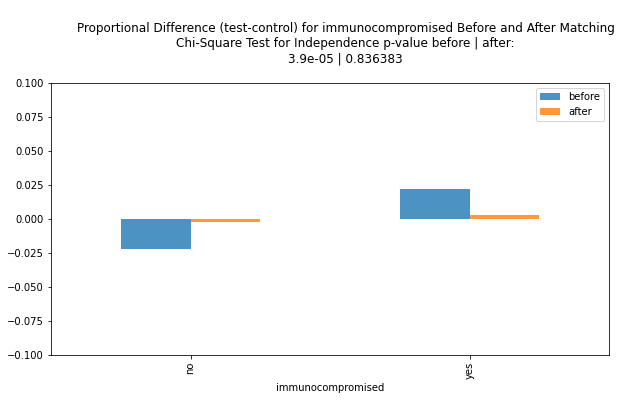

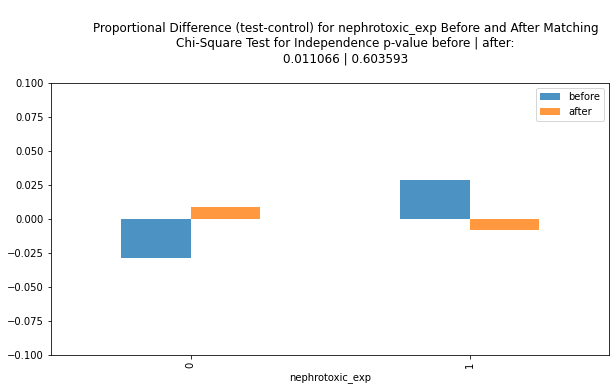

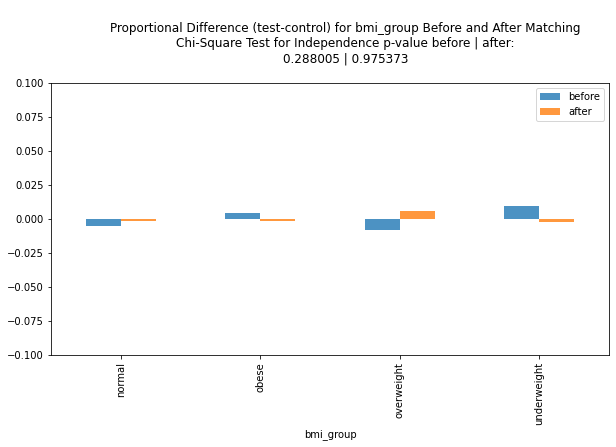

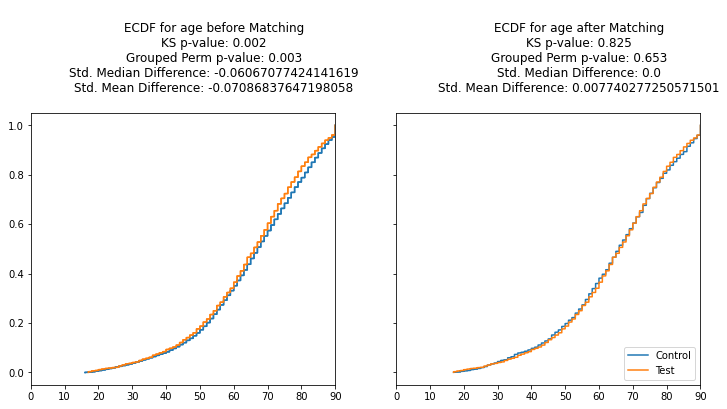

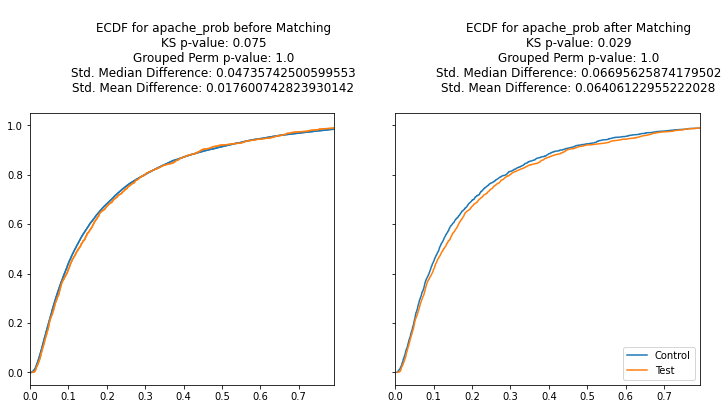

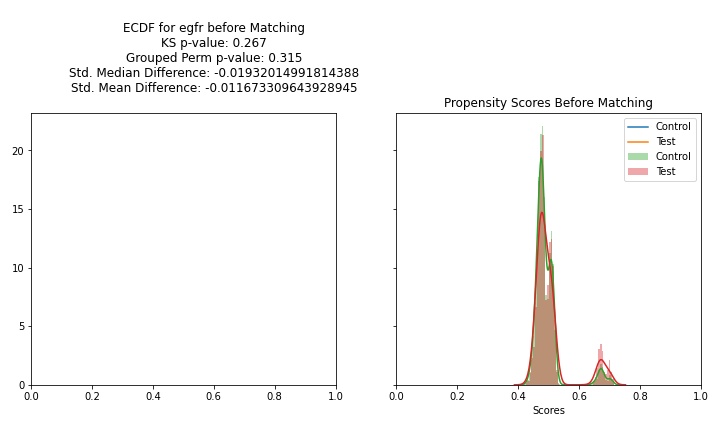

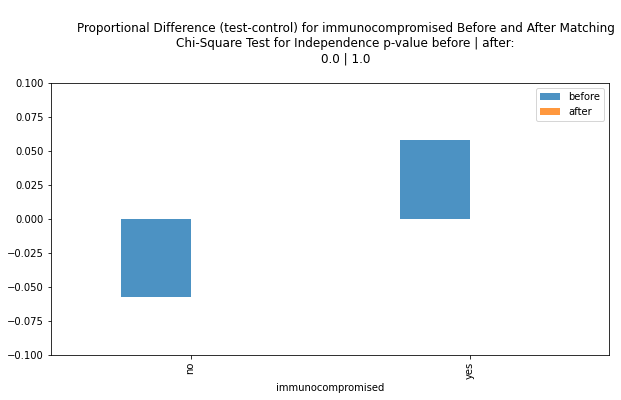

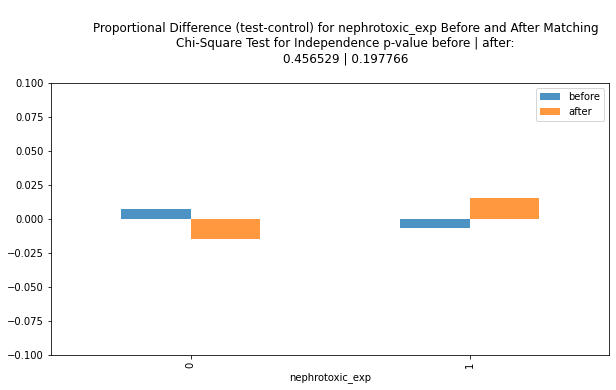

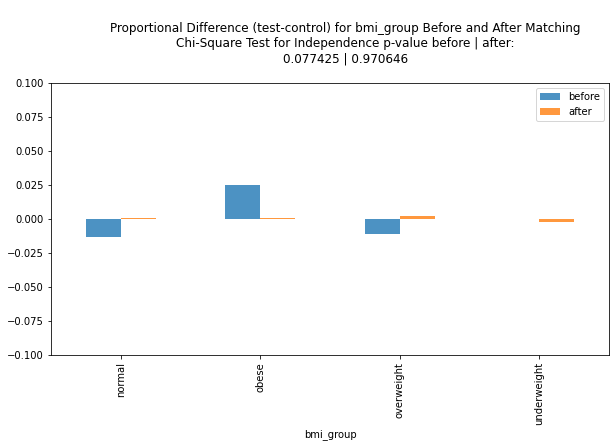

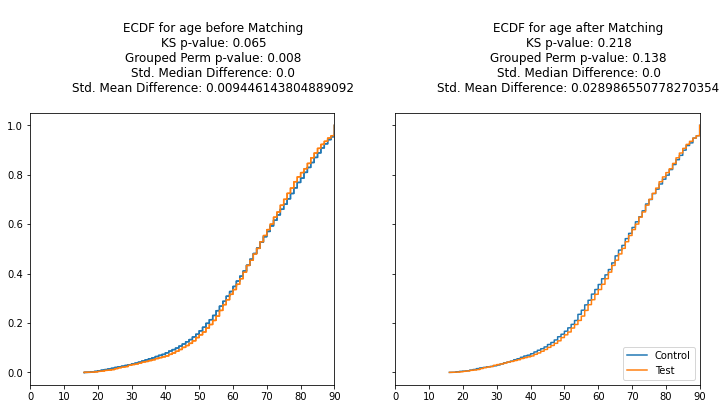

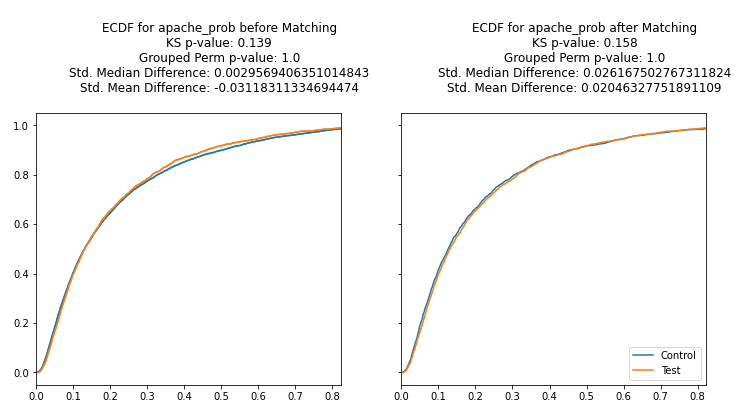

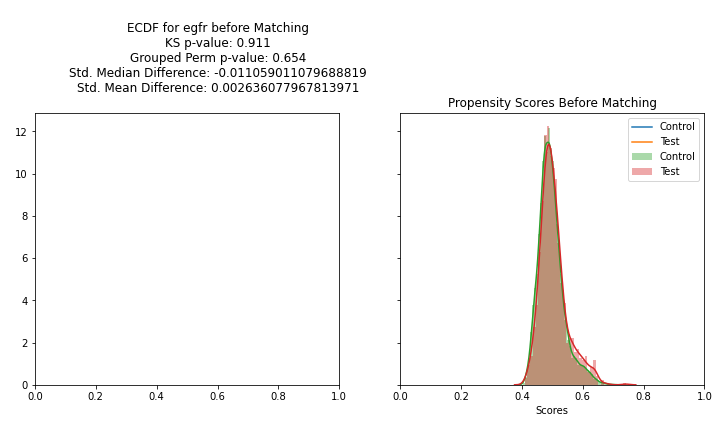

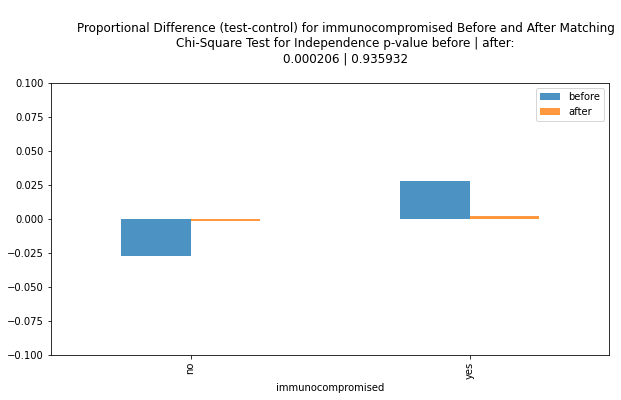

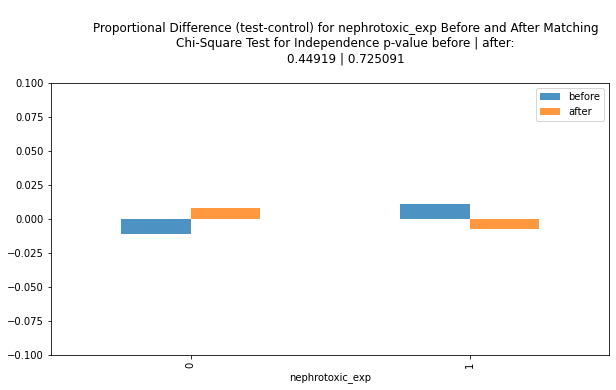

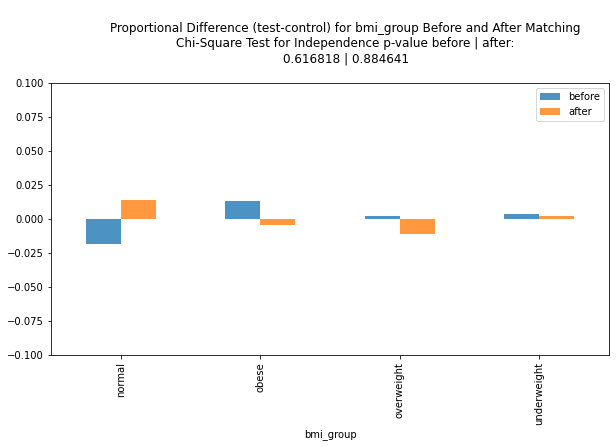

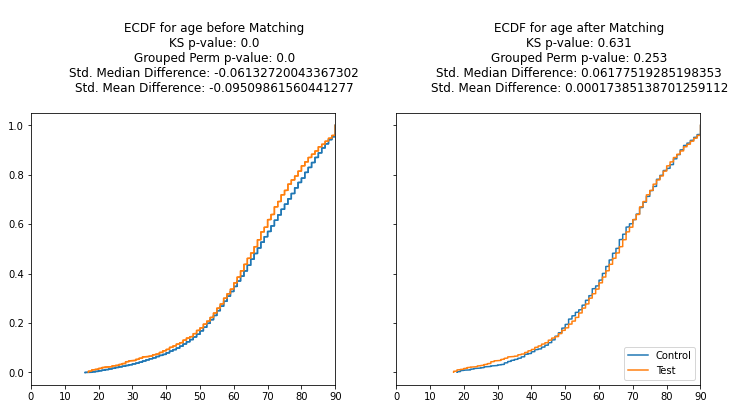

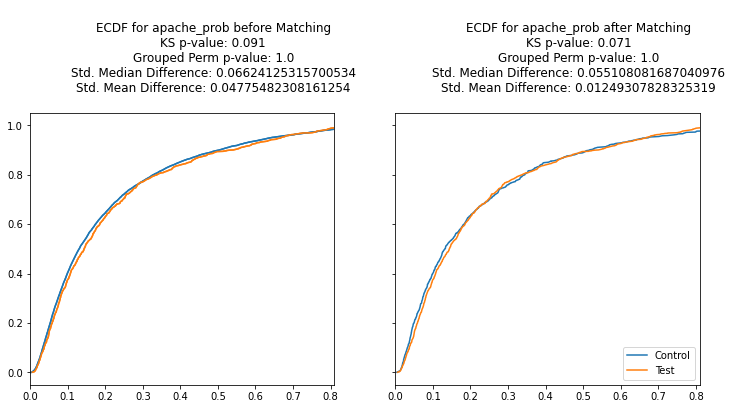

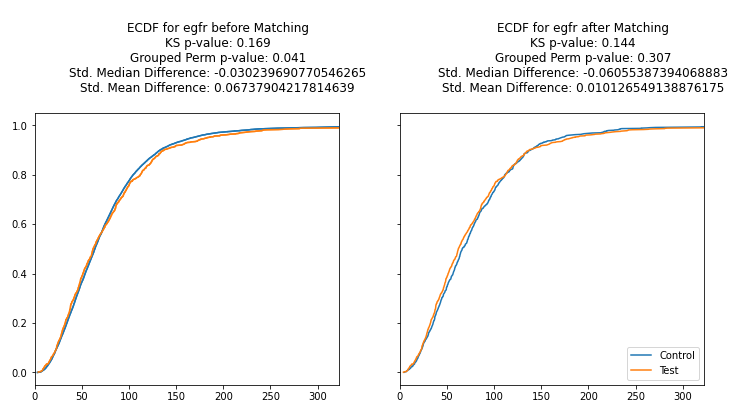

In [15]:
matched_data = OrderedDict()

for c_name, comparison in comparisons.items():
    print(f'{"="*5}{c_name}{"="*5}')
    # number of people in the groups
    exposure, control = comparison['exposure'], comparison['control']
    N = exposure.shape[0] + control.shape[0]
    print(f'Exposure: {exposure.shape[0]:5d} ({exposure.shape[0]/N*100.0:4.1f}%)')
    print(f'Control: {control.shape[0]:5d} ({control.shape[0]/N*100.0:4.1f}%)')
        
    m = utils.propensity_match(**comparison, verbose=True)
    plt.show() 
    
    m.matched_data.reset_index()
    matched_data[c_name] = m.matched_data
        
    # calculate a contingency table for each "strata"
    # here the strata are a match between a single patient in the minority group
    # and 1 or more patients in the majority group
    cm = utils.get_contingency_tables(m, outcome_var='aki')

    # CMH tests for the significance of the odds ratio between matched pairs
    pval, R, ci = utils.cmh_test(cm, alpha=0.05)
    pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'

    print('Result of propensity score followed by matching:')
    print(f'p {pval_str}.\nOdds ratio: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

## Subgroups of eGFR in other comparisons


We'd like to investigate whether subgrouping based off of eGFR at the time of ICU admission makes any difference.

In [16]:
def add_grouped_var(x: pd.Series, bins=[(0, 60)]):
    y = x.copy()
    bin_order = []
    for b in bins:
        idx = (x > b[0]) & (x <= b[1])
        bin_name = f'{b[0]} - {b[1]}'
        y.loc[idx] = bin_name
        bin_order.append(bin_name)


    idx = (x > b[1])
    bin_name = f'> {b[1]}'
    y.loc[idx] = bin_name
    bin_order.append(bin_name)
    
    return y, bin_order

for c_name, comparison in comparisons.items():
    exposure, control = comparison['exposure'].copy(), comparison['control'].copy()
    covariates = comparison['covariates']
    
    exposure['egfr_groups'], bin_order = add_grouped_var(exposure['egfr'])
    control['egfr_groups'], bin_order = add_grouped_var(control['egfr'])
    
    # calculate odds ratio in each group
    for b in bin_order:
        n_exp = (exposure['egfr_groups']==b).sum()
        n_ctl = (control['egfr_groups']==b).sum()
        print(f'{c_name}, {b}: exp {n_exp}, ctl {n_ctl}')

v+z vs. v+c, 0 - 60: exp 2867, ctl 12236
v+z vs. v+c, > 60: exp 3005, ctl 12576
v+z vs. v+m, 0 - 60: exp 857, ctl 12236
v+z vs. v+m, > 60: exp 847, ctl 12576
v+z vs. v+c, 48hr, 0 - 60: exp 1433, ctl 5693
v+z vs. v+c, 48hr, > 60: exp 1622, ctl 6651
v+z vs. v+m, 48hr, 0 - 60: exp 500, ctl 5693
v+z vs. v+m, 48hr, > 60: exp 566, ctl 6651


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


v+z vs. v+c
v+z vs. v+c - 0 - 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 12236
n minority: 2867
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.71%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000000,1.000000
1,nephrotoxic_exp,0.829042,0.949270
2,bmi_group,0.000058,0.295945


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.046,0.334,0.086,0.277,0.000000,-0.072394,0.035615,-0.016438
1,apache_prob,0.129,0.550,1.000,1.000,0.012519,0.029376,-0.024896,-0.020808
2,egfr,0.398,0.215,0.468,0.304,0.041462,0.064410,0.026192,0.026672


v+z vs. v+c - > 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 12576
n minority: 3005
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.57%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000000,0.967092
1,nephrotoxic_exp,0.023469,0.977666
2,bmi_group,0.825642,0.949792


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.011,0.355,0.007,0.761,0.000000,0.000000,0.045701,0.000705
1,apache_prob,0.000,0.127,1.000,1.000,0.048665,0.038806,0.016177,0.019042
2,egfr,0.104,0.560,0.484,0.115,0.032184,0.019117,0.024692,0.004442


v+z vs. v+m
v+z vs. v+m - 0 - 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 12236
n minority: 857
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.89%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.015341,0.373427
1,nephrotoxic_exp,0.362386,0.248734
2,bmi_group,0.043208,0.600097


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.000,0.393,0.001,0.235,-0.138616,0.000000,-0.144581,-0.049478
1,apache_prob,0.519,0.825,1.000,1.000,0.045344,0.017163,0.001214,-0.041987
2,egfr,0.375,0.662,0.745,0.604,-0.041857,0.101660,-0.050275,0.044267


v+z vs. v+m - > 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 12576
n minority: 847
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.37%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000941,0.724973
1,nephrotoxic_exp,0.013945,0.365723
2,bmi_group,0.182343,0.386103


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.174,1.000,0.167,0.950,0.000000,0.000000,-0.023826,0.005765
1,apache_prob,0.192,0.898,1.000,1.000,0.059359,0.040363,0.030295,0.020594
2,egfr,0.735,0.384,0.318,0.338,-0.005199,0.015377,0.013455,-0.037390


v+z vs. v+c, 48hr
v+z vs. v+c, 48hr - 0 - 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 5693
n minority: 1433
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.37%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000000,1.000000
1,nephrotoxic_exp,0.241864,0.534722
2,bmi_group,0.146787,0.849502


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.064,0.233,0.041,0.094,0.000000,0.000000,0.013670,-0.022202
1,apache_prob,0.210,0.965,1.000,1.000,-0.019290,0.002124,-0.032689,-0.004031
2,egfr,0.457,0.499,0.692,0.612,0.040457,0.030269,0.025244,0.032417


v+z vs. v+c, 48hr - > 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 6651
n minority: 1622
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.54%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000000,1.000000
1,nephrotoxic_exp,0.939905,0.337405
2,bmi_group,0.641180,0.182772


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.440,0.687,0.101,0.774,0.029888,0.030668,-0.000289,0.003857
1,apache_prob,0.325,0.076,1.000,1.000,0.013779,0.058670,-0.035754,0.051155
2,egfr,0.714,0.902,0.568,0.512,0.014239,0.021209,0.016991,-0.002994


v+z vs. v+m, 48hr
v+z vs. v+m, 48hr - 0 - 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 5693
n minority: 500
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 55.27%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.185810,1.000000
1,nephrotoxic_exp,0.211301,0.507438
2,bmi_group,0.160017,0.812985


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.003,0.234,0.046,0.877,-0.138546,-0.068080,-0.137364,-0.052830
1,apache_prob,0.112,0.591,1.000,1.000,0.053855,-0.075112,0.067384,-0.045819
2,egfr,0.076,0.248,0.058,0.115,-0.084675,0.127306,-0.085641,0.038219


v+z vs. v+m, 48hr - > 60
Formula:
status ~ age+apache_prob+immunocompromised+egfr+nephrotoxic_exp+bmi_group
n majority: 6651
n minority: 566
Fitting Models on Balanced Samples: 1\100

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 54.02%


/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,var,before,after
0,immunocompromised,0.000289,0.542149
1,nephrotoxic_exp,0.944843,0.523028
2,bmi_group,0.966188,0.874281


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.138,0.031,0.008,0.007,0.000000,0.176327,-0.076316,0.076948
1,apache_prob,0.478,0.547,1.000,1.000,0.016253,0.031206,0.024099,0.056885
2,egfr,0.008,0.680,0.081,0.243,0.063992,0.005128,0.153674,-0.031753


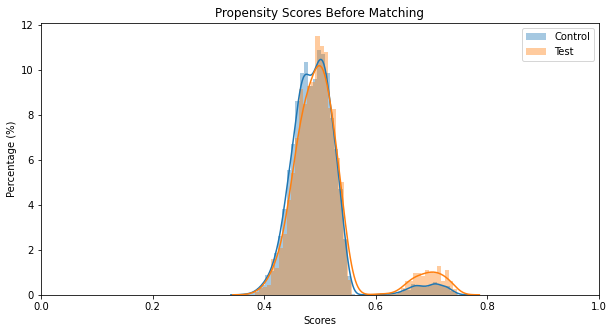

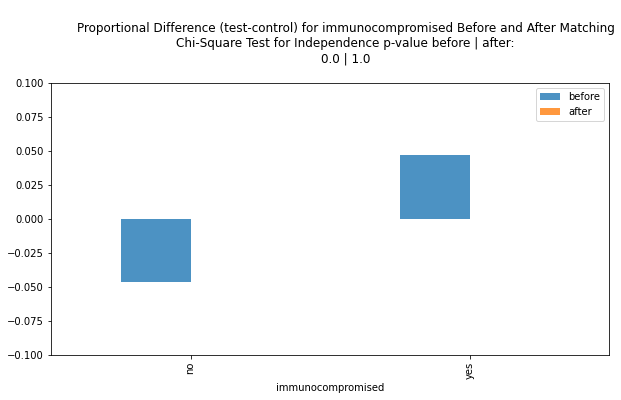

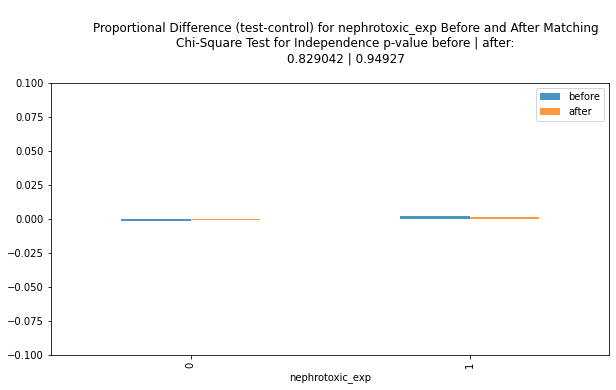

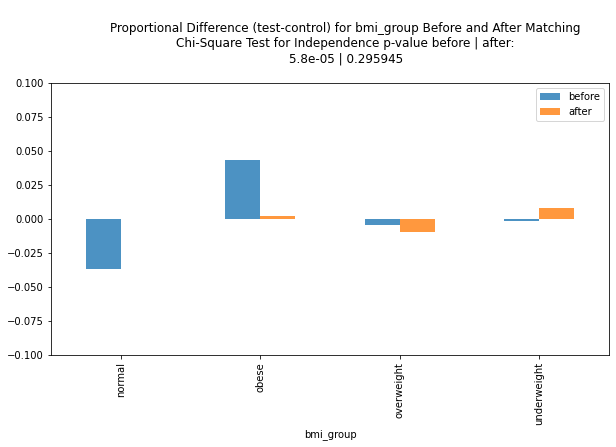

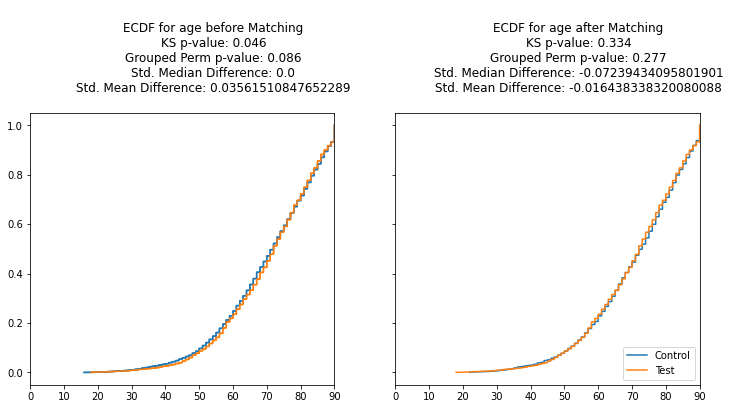

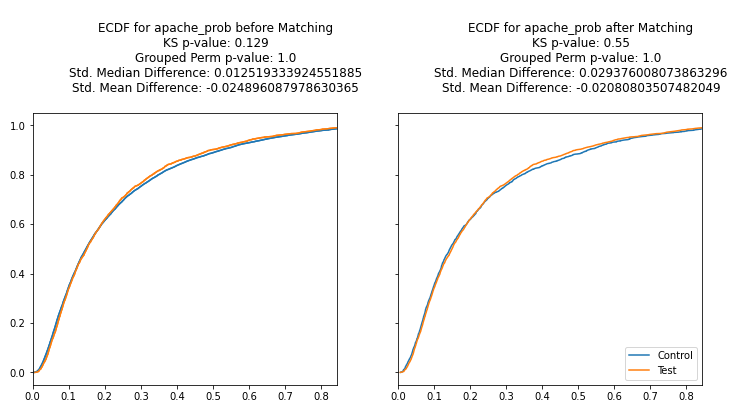

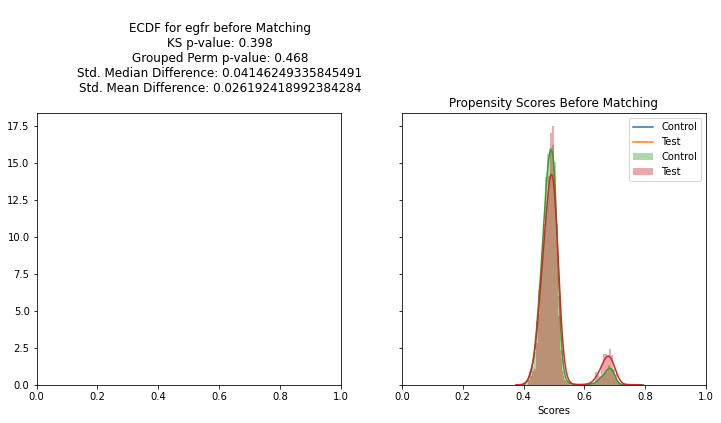

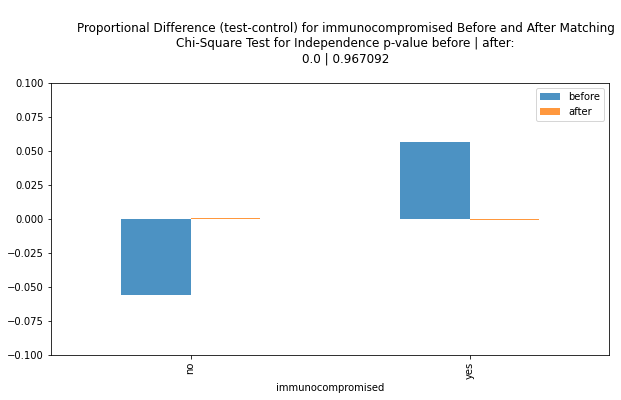

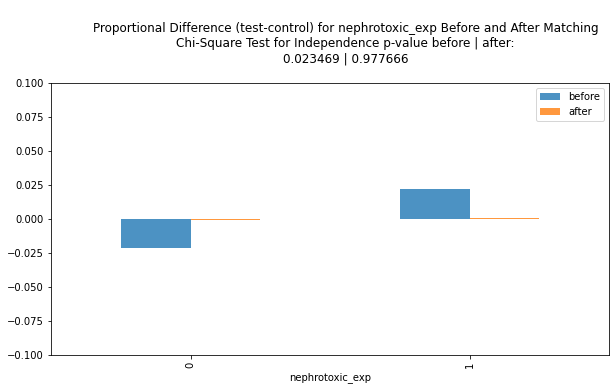

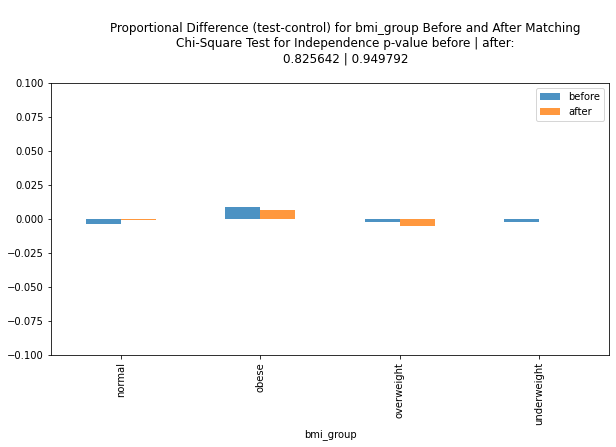

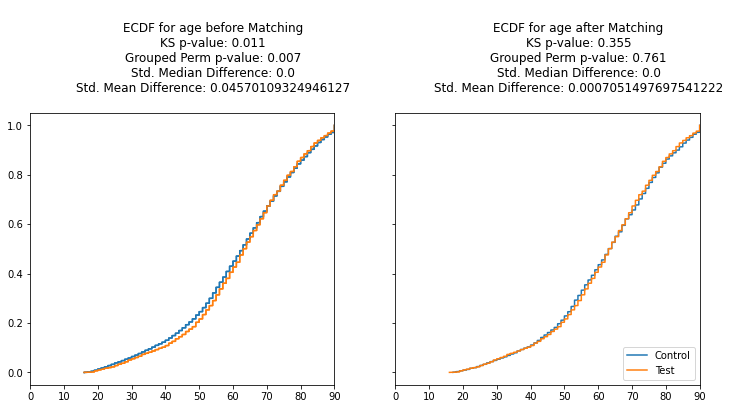

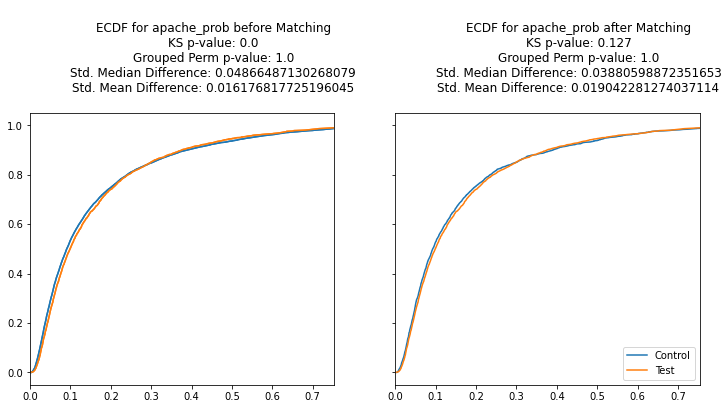

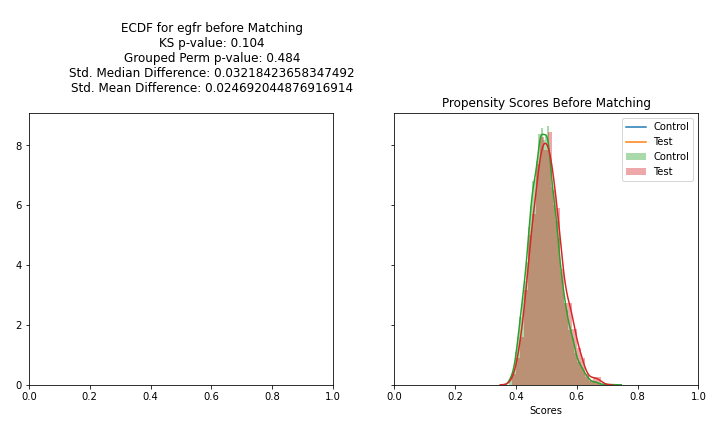

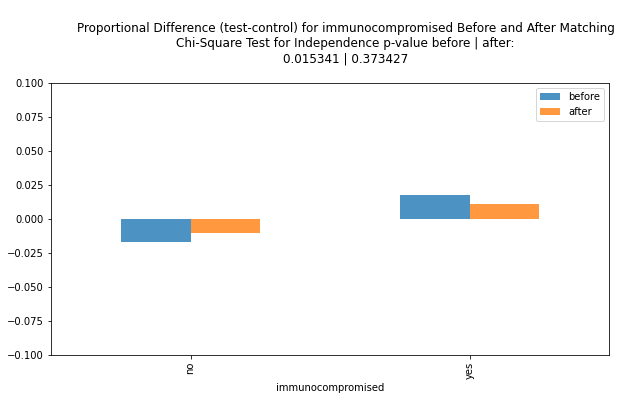

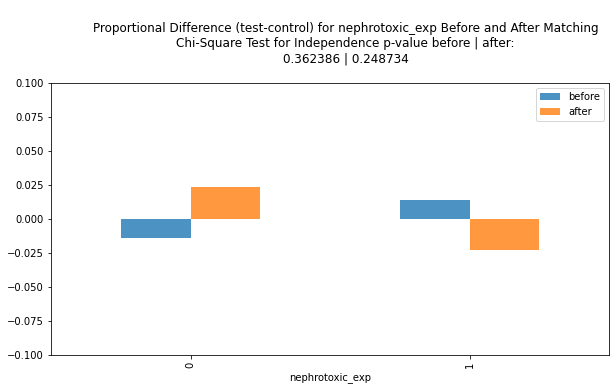

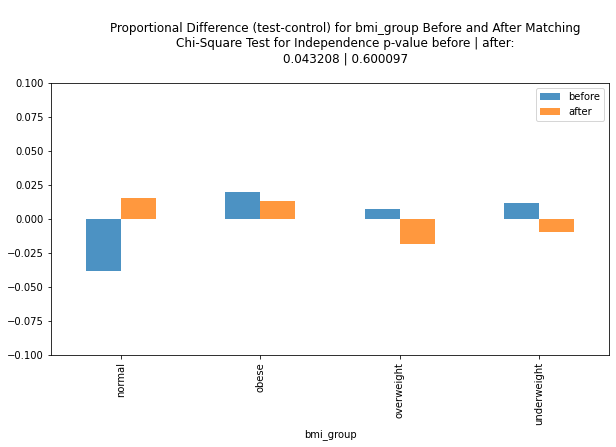

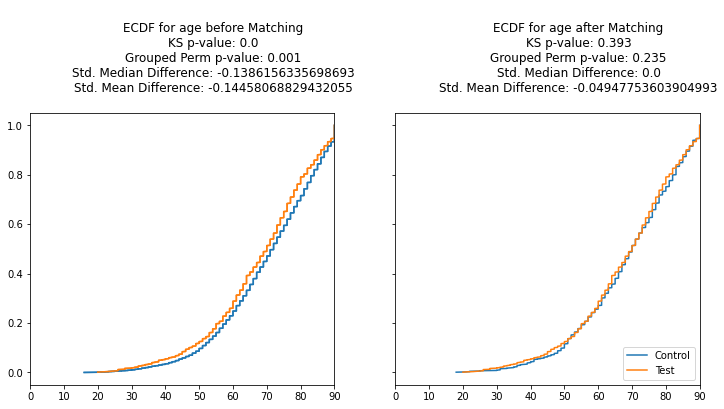

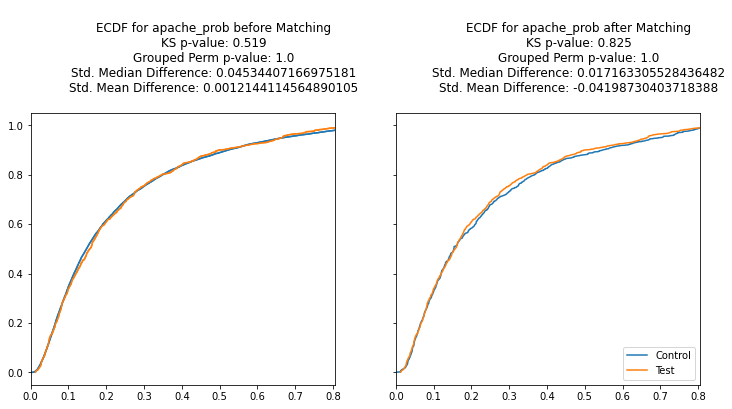

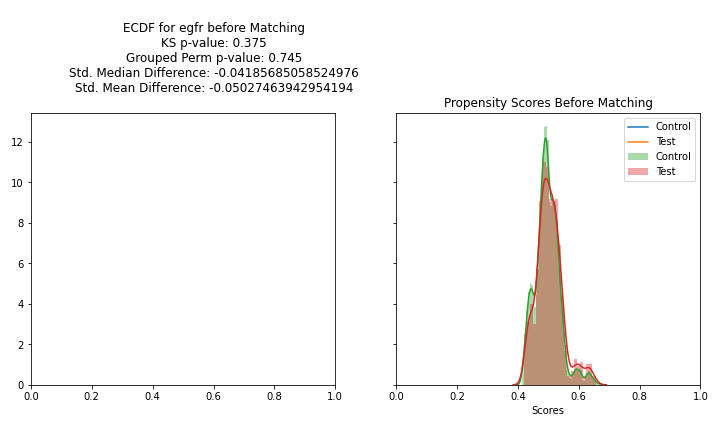

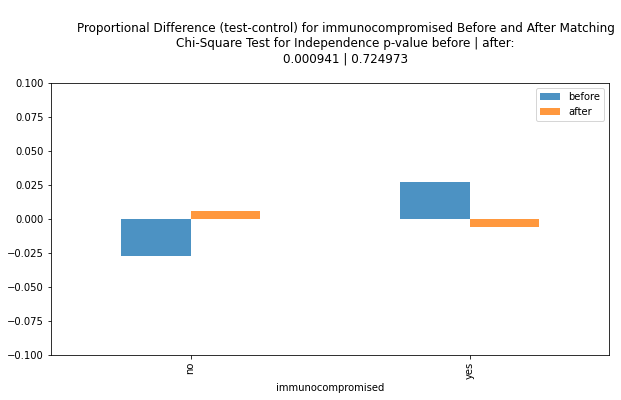

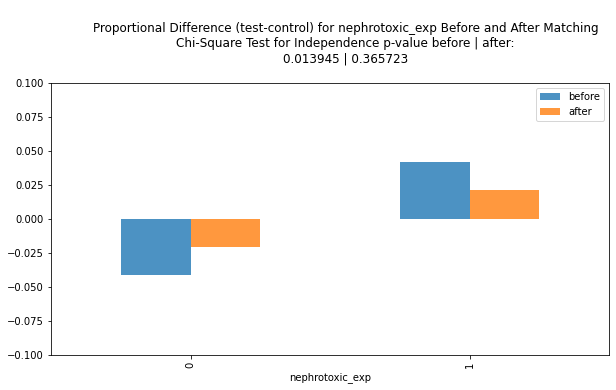

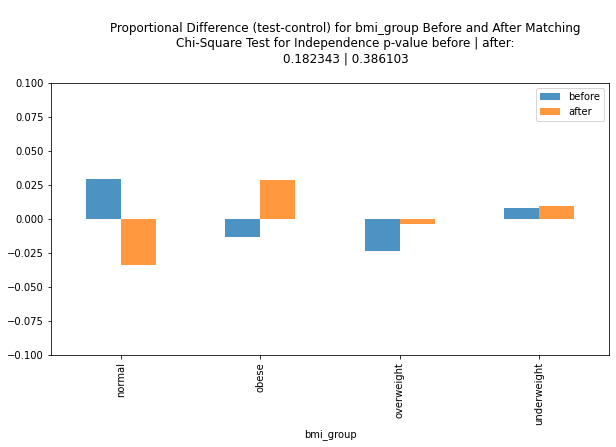

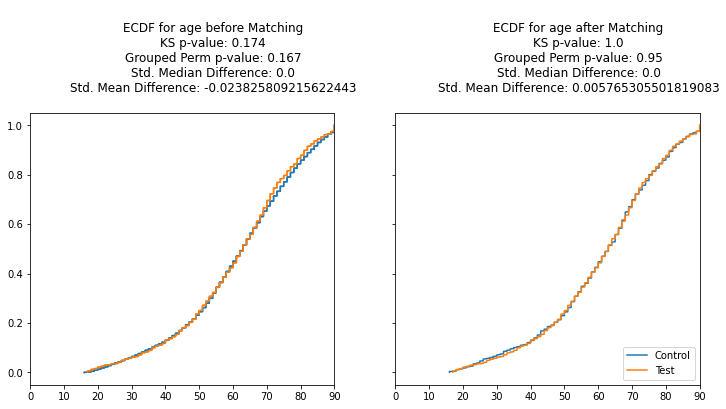

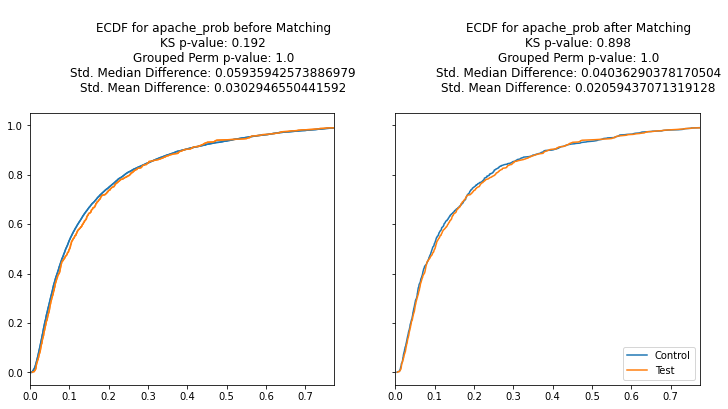

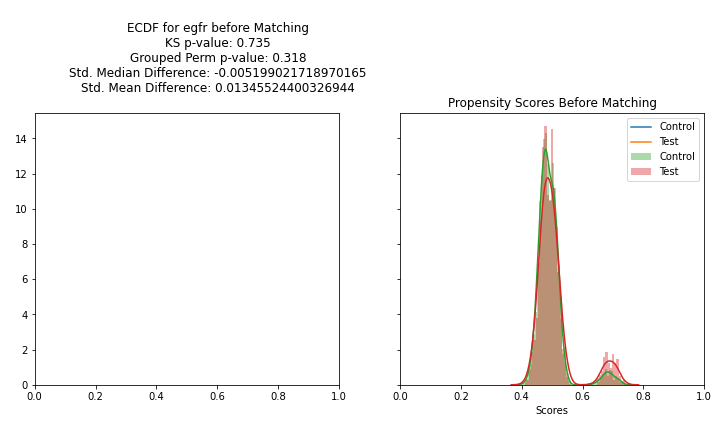

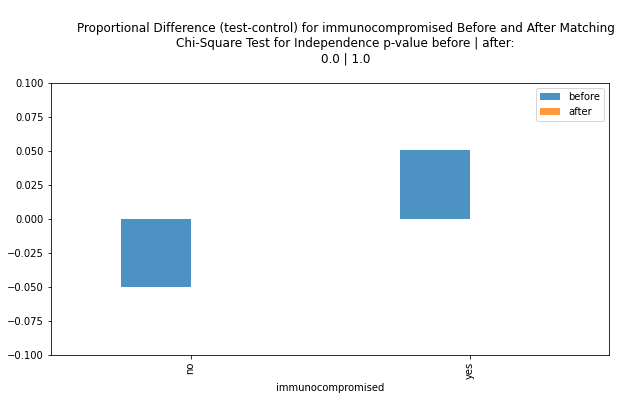

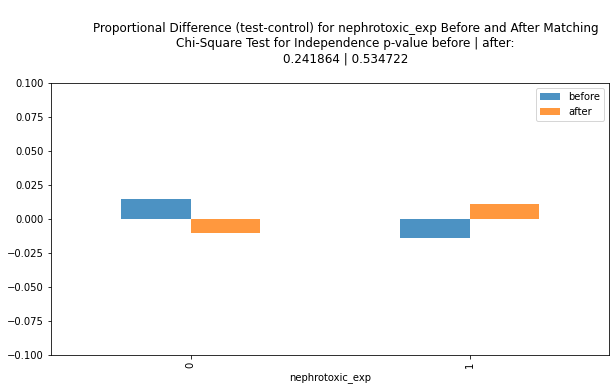

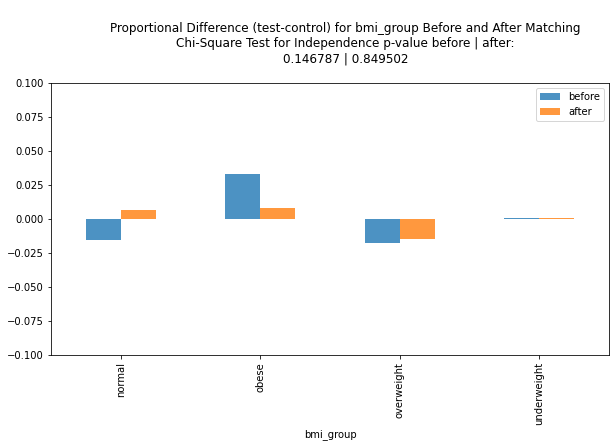

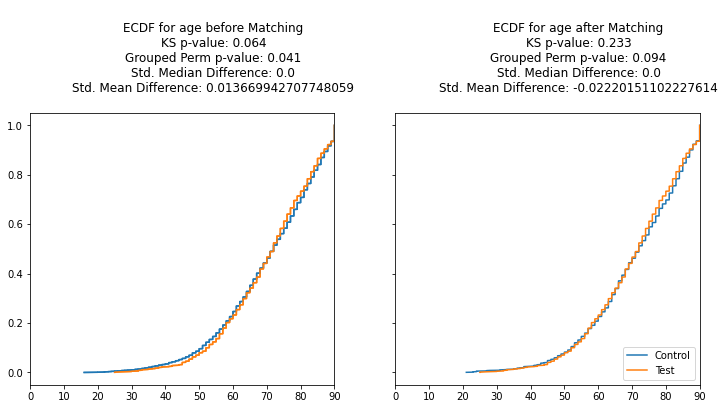

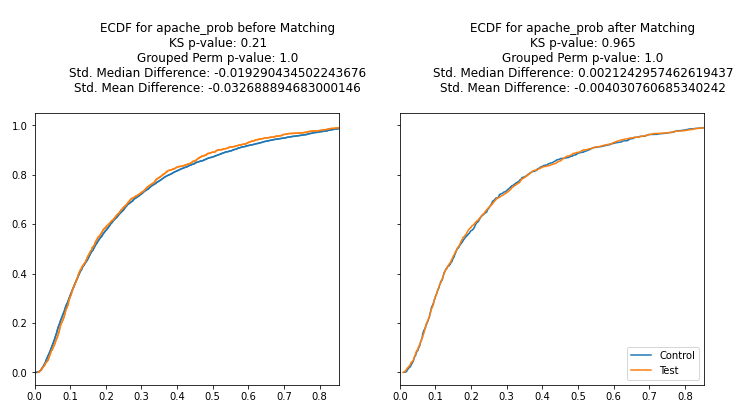

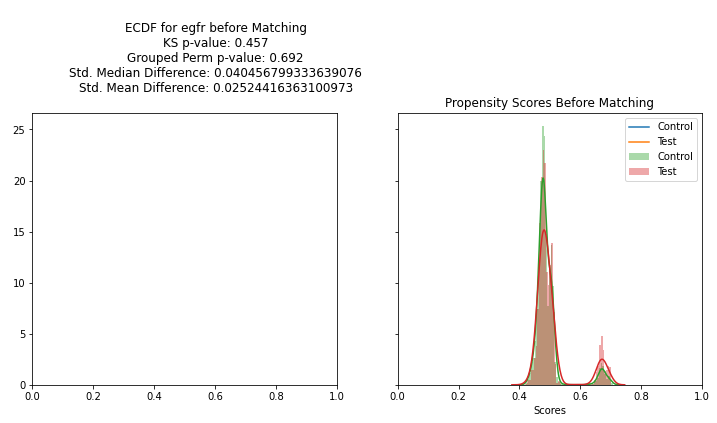

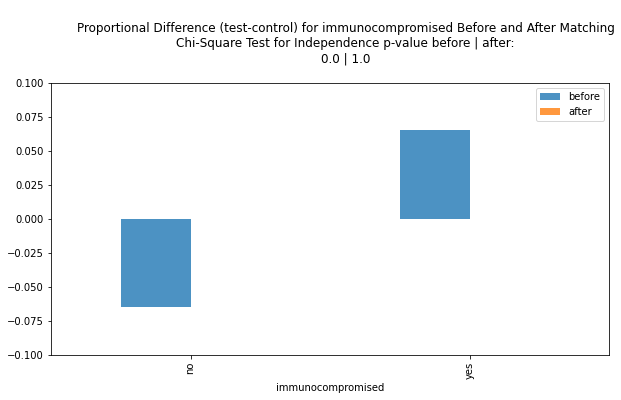

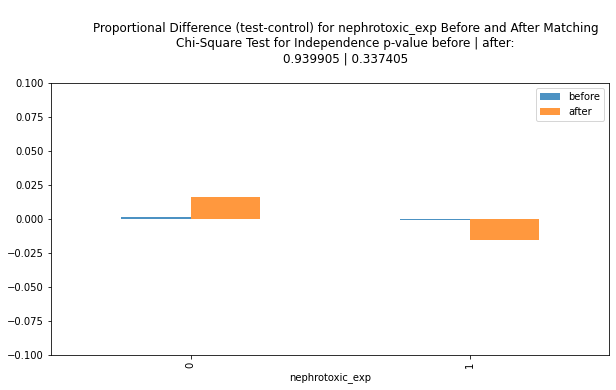

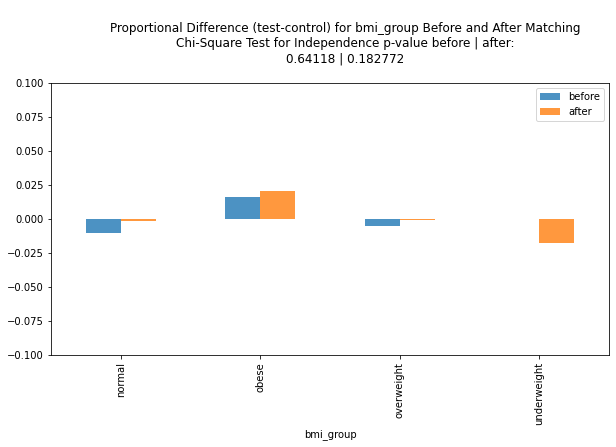

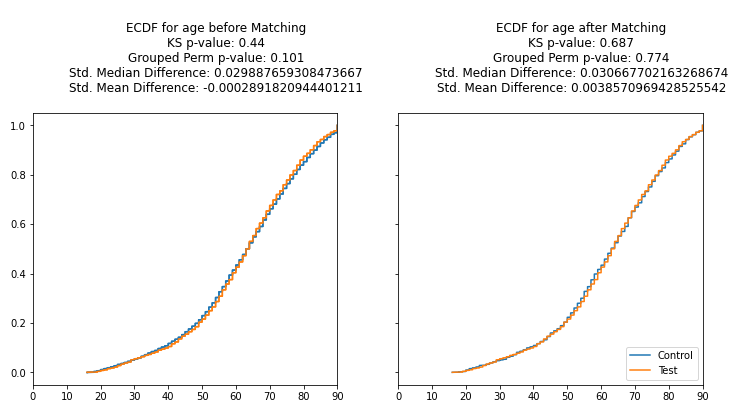

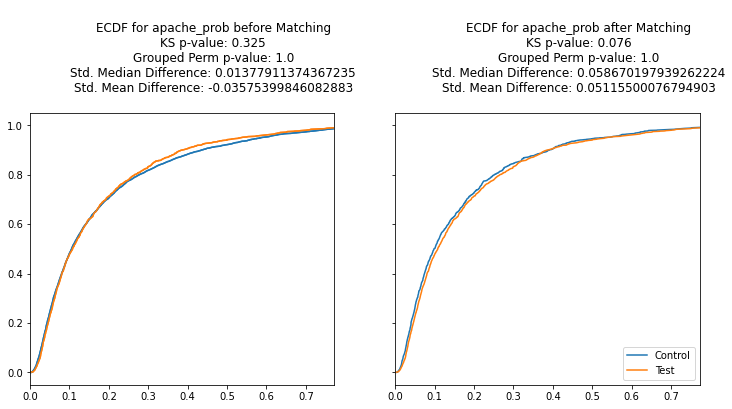

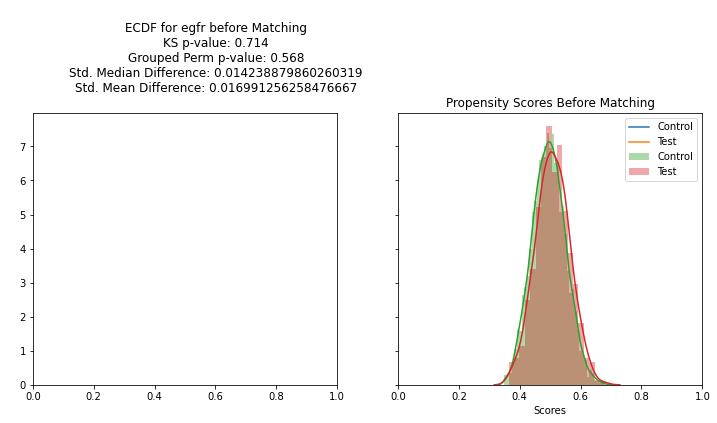

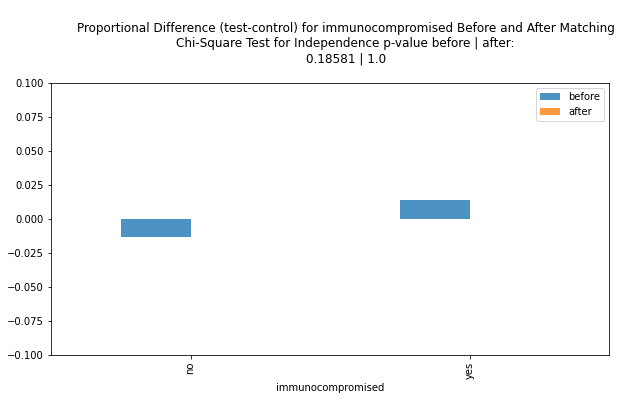

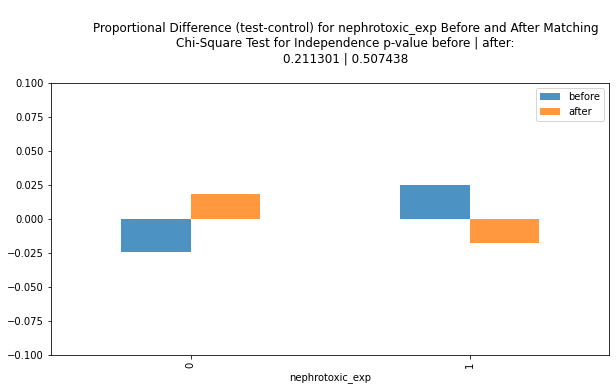

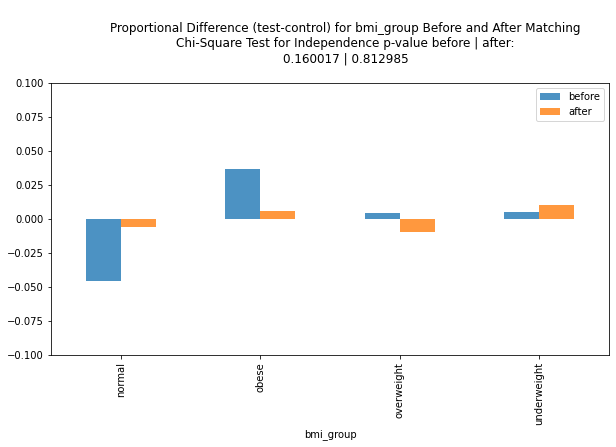

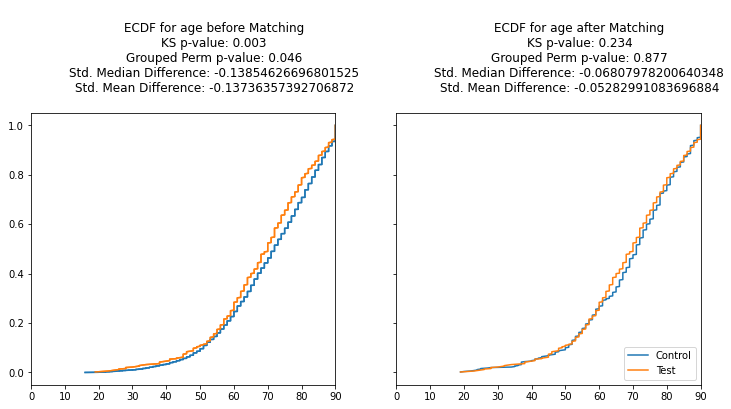

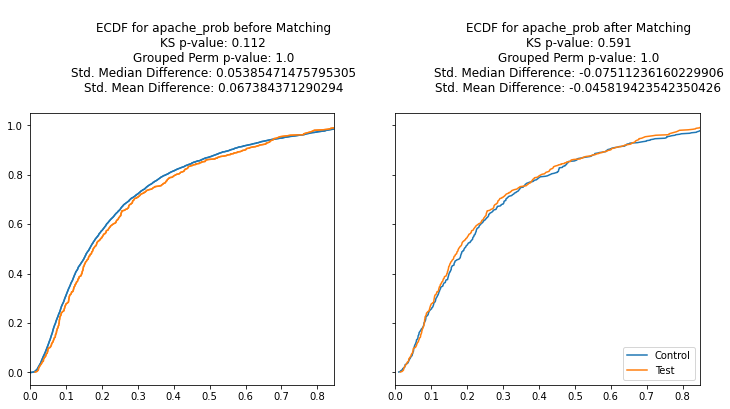

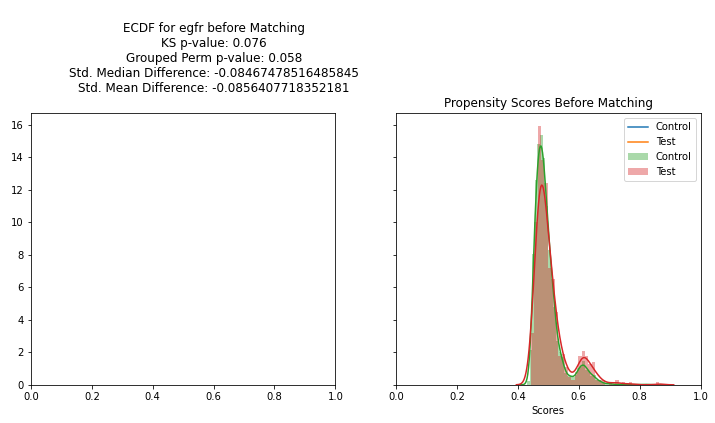

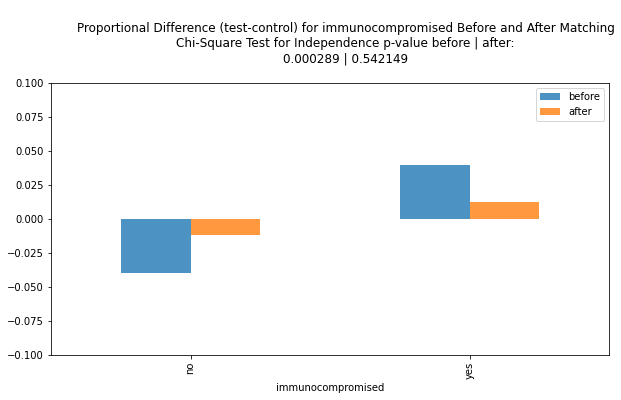

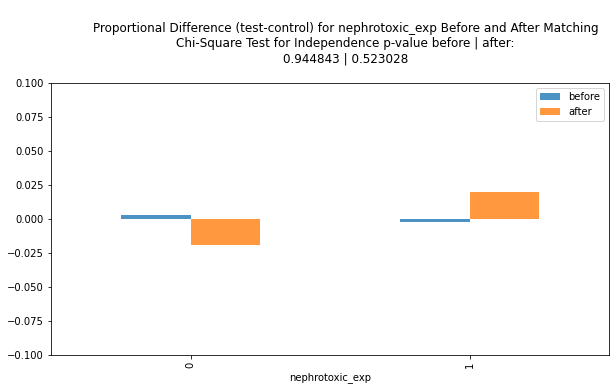

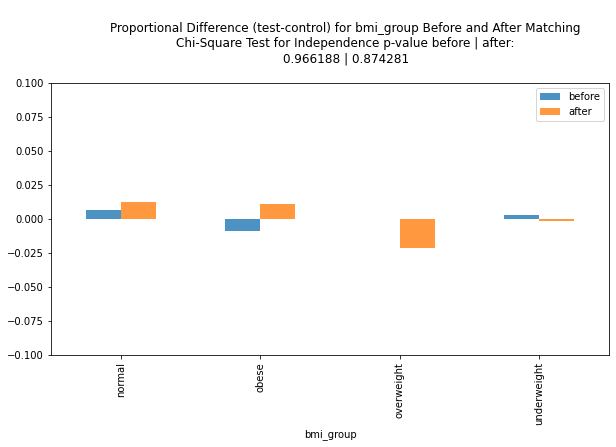

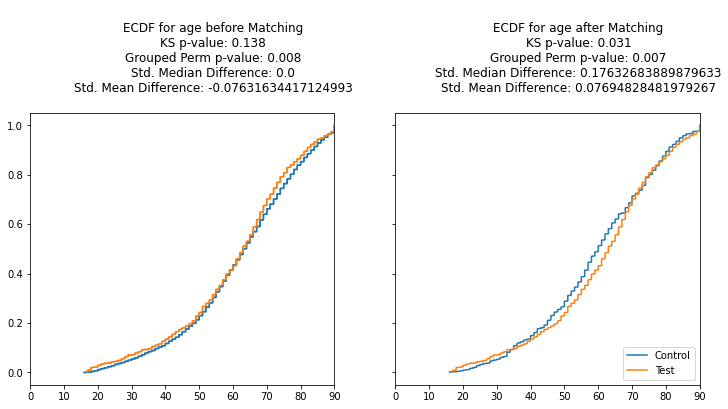

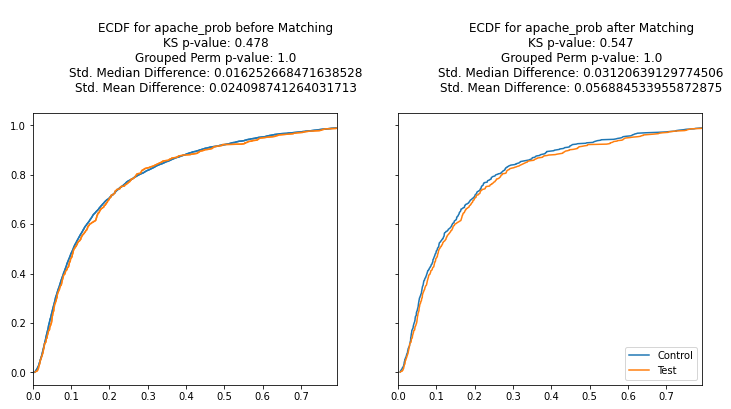

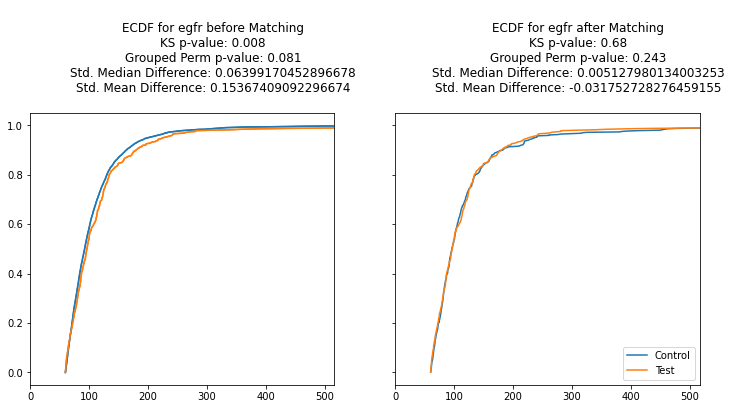

In [17]:
# do grouped propensity matching
egfr_ps, egfr_cm = {}, {}
seed_base = 1000
i = 0

for c_name, comparison in comparisons.items():
    exposure, control = comparison['exposure'].copy(), comparison['control'].copy()
    covariates = comparison['covariates']
    
    exposure['egfr_groups'], bin_order = add_grouped_var(exposure['egfr'])
    control['egfr_groups'], bin_order = add_grouped_var(control['egfr'])
    
    egfr_ps[c_name] = {}
    egfr_cm[c_name] = {}
    print(c_name)
    # calculate odds ratio in each group
    for b in bin_order:
        propensity_vars = {
            'exposure': exposure.loc[exposure['egfr_groups']==b],
            'control': control.loc[control['egfr_groups']==b],
            'covariates': covariates,
            'seed': seed_base+i
        }

        print(f'{c_name} - {b}')
        egfr_ps[c_name][b] = utils.propensity_match(**propensity_vars, balance=True, verbose=True)
        plt.show()
        
        # get CMs
        egfr_cm[c_name][b] = utils.get_contingency_tables(egfr_ps[c_name][b], outcome_var='aki')

        i+=1

In [18]:
egfr_ps['v+z vs. v+c']['0 - 60'].matched_data['aki'].value_counts()

/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    5111
1     623
Name: aki, dtype: int64

In [19]:
# print out final results
for c_name, comparison in comparisons.items():
    print(f'{"="*5}{c_name}{"="*5}')
    for b in bin_order:
        m = egfr_ps[c_name][b]
        cm = egfr_cm[c_name][b]

        pval, R, ci = utils.cmh_test(cm, alpha=0.05)
        pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'

        n = m.matched_data['match_id'].nunique()
        idx = m.matched_data['status'] == 1
        n_exposed = m.matched_data.loc[idx]['record_id'].nunique()
        n_control = m.matched_data.loc[~idx]['record_id'].nunique()
        print(f'{b}: N={n} ({n_exposed} exp, {n_control} ctl). p {pval_str}. OR: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

    print('\n')

=====v+z vs. v+c=====
0 - 60: N=2867 (2867 exp, 2396 ctl). p = 0.033. OR: 0.83 [0.70 - 0.98].
> 60: N=3005 (3005 exp, 2523 ctl). p < 0.001. OR: 0.65 [0.54 - 0.79].


=====v+z vs. v+m=====
0 - 60: N=857 (857 exp, 829 ctl). p = 0.095. OR: 0.78 [0.58 - 1.03].
> 60: N=847 (847 exp, 798 ctl). p = 0.031. OR: 0.65 [0.45 - 0.95].


=====v+z vs. v+c, 48hr=====
0 - 60: N=1433 (1433 exp, 1189 ctl). p = 0.069. OR: 0.78 [0.61 - 1.01].
> 60: N=1622 (1622 exp, 1358 ctl). p < 0.001. OR: 0.55 [0.43 - 0.72].


=====v+z vs. v+m, 48hr=====
0 - 60: N=500 (500 exp, 464 ctl). p = 0.278. OR: 0.77 [0.50 - 1.18].
> 60: N=566 (566 exp, 522 ctl). p < 0.001. OR: 0.41 [0.25 - 0.68].




/home/alyssayc/vancomycin-nephrotoxicity/py_37_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
